# **주요 내용**

*   Separable Convolutional Layer, Inception V3 구조 실험


1.   build_model_1(): 1 block당 kernel_size=3을 2번씩 사용한 구조
2.   build_model_2(): 1 block당 kernel_size=5을 1번 사용한 구조
3.   build_model_3(): build_model_1()의 3, 4번째 block을 Separable Conv로 대체
4.   build_model_4(): build_model_2()의 3, 4번째 block을 Separable Conv로 대체
5.   build_model_5(): build_model_1()의 3, 4번째 block의 conv와 pool을 분리
6.   build_model_4(): build_model_2()의 3, 4번째 block의 conv와 pool을 분리

*   Optimizer 추가
*   Callback 함수 추가

In [1]:
notebookName = "20200520"
notebookName

'20200520'

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16691539816464082621, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13772831576195317823
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7333182865406608000
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9806949890168270122
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [4]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [5]:
!nvidia-smi

Wed May 20 07:59:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**파일 압축 해제 (드라이브에는 *.zip 파일 형식으로 저장되어 있음)**

In [7]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['I4F02933JSI0', 'I4F02224SDY0', 'GSM06044JBY0', 'GSM03634SJY0', 'GSM03823YJK0']
50


***.pcm to *.wav**

In [8]:
import wave

for i, folder_path in enumerate(sorted(os.listdir(pcm_path))): # sorted!!!
    print("{}\t{}".format(i, folder_path))

    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(sorted(file_list_pcm)): # sorted!!!
        with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

0	GSF03031LJH0
1	GSF03732JJH0
2	GSF04122LHK0
3	GSF04524CJI0
4	GSF04623LWJ0
5	GSF04923PEY0
6	GSF05134JHK0
7	GSF05432KSY0
8	GSF05733HBH0
9	GSF05844LJR0
10	GSF06654KES0
11	GSF06742CKA0
12	GSF06833JYK0
13	GSF06934SYN0
14	GSF07132LCY0
15	GSF08142LDH0
16	GSF08233NEH0
17	GSF08333KJH0
18	GSF09025WYY0
19	GSF09431SHY0
20	GSF09844KKS0
21	GSM02434AGS0
22	GSM02544LHS0
23	GSM03224CHD0
24	GSM03321SDK0
25	GSM03634SJY0
26	GSM03823YJK0
27	GSM04233KMS0
28	GSM04424JBRC
29	GSM05953CJH0
30	GSM06044JBY0
31	GSM06235BJH0
32	GSM07042NSK0
33	GSM07355MIW0
34	GSM09534JHD0
35	GSM09644KCK0
36	GSM09752SCY0
37	I4F02224SDY0
38	I4F02631KSM0
39	I4F02821YRR0
40	I4F02933JSI0
41	I4F03423KSR0
42	I4F03543KSY0
43	I4F03922LKY0
44	I4F04732OIY0
45	I4F05332CJH0
46	I4F05625JSY0
47	I4F07443LJA0
48	I4F07633JSI0
49	I4F07852PKJ0


In [0]:
import numpy as np

num_labels = 50
num_features = 100
data_length = 8000  # 16,000 * 0.5

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

**train data, test data로 구분하여 numpy 저장 (*.npz)**

In [44]:
# save features as *.npz format

from scipy.io import wavfile

data = np.zeros((num_labels * num_features, data_length))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        start = int(len(samples) - data_length) // 2
        end = start + data_length
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i

train_data = data[select_train_data * num_labels]
train_labels = labels[select_train_data * num_labels]

test_data = data[select_test_data * num_labels]
test_labels = labels[select_test_data * num_labels]

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print("train_data.shape: {}, train_labels.shape: {}".format(train_data.shape, train_labels.shape))
print("test_data.shape: {}, test_labels.shape: {}".format(test_data.shape, test_labels.shape))

train_data.shape: (4000, 8000), train_labels.shape: (4000,)
test_data.shape: (1000, 8000), test_labels.shape: (1000,)


In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def my_split(train_data, train_labels):
    test_size = 0.2

    X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels, test_size = test_size)

    x_train = X_train.reshape(len(X_train), data_length, 1)
    x_val = X_val.reshape(len(X_val), data_length, 1) 

    y_train = to_categorical(Y_train)
    y_val = to_categorical(Y_val)

    # standarization
    mean = x_train.mean()
    x_train -= mean
    std = x_train.std()
    x_train /= std

    x_val -= mean
    x_val /= std

    return x_train, y_train, x_val, y_val, mean, std

**Build Model**

In [0]:
from tensorflow.keras.applications.xception import Xception, decode_predictions

xcep = Xception(input_shape=(299,299,3))
# xcep.summary()

In [23]:
xcep.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
def build_model_1(model_input, i):
    # block 1
    x = layers.Conv1D(name = "block1_conv1", filters = 32, kernel_size = 3, strides = 1, padding = 'same')(model_input)
    x = layers.ReLU(name = "block1_conv1_act")(x)
    x = layers.BatchNormalization(name = "block1_conv1_bn")(x)

    x = layers.Conv1D(name = "block1_conv2", filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block1_conv2_act")(x)
    x = layers.BatchNormalization(name = "block1_conv2_bn")(x)
    
    x = layers.MaxPooling1D(name = "block1_pool", pool_size = 2)(x)


    # block 2
    x = layers.Conv1D(name = "block2_conv1", filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv1_act")(x)
    x = layers.BatchNormalization(name = "block2_conv1_bn")(x)
    
    x = layers.Conv1D(name = "block2_conv2", filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv2_act")(x)
    x = layers.BatchNormalization(name = "block2_conv2_bn")(x)    
    
    x = layers.MaxPooling1D(name = "block2_pool", pool_size = 2)(x)


    # block 3
    x = layers.Conv1D(name = "block3_conv1", filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block3_conv1_act")(x)
    x = layers.BatchNormalization(name = "block3_conv1_bn")(x)
    
    x = layers.Conv1D(name = "block3_conv2", filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block3_conv2_act")(x)
    x = layers.BatchNormalization(name = "block3_conv2_bn")(x)    
    
    x = layers.MaxPooling1D(name = "block3_pool", pool_size = 2)(x)


    # block 4
    x = layers.Conv1D(name = "block4_conv1", filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block4_conv1_act")(x)
    x = layers.BatchNormalization(name = "block4_conv1_bn")(x)
    
    x = layers.Conv1D(name = "block4_conv2", filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block4_conv2_act")(x)
    x = layers.BatchNormalization(name = "block4_conv2_bn")(x)    
    
    x = layers.MaxPooling1D(name = "block4_pool", pool_size = 2)(x)


    # out
    x = layers.GlobalAveragePooling1D(name = "avg_pool")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "predictions")(x)

    model = Model(model_input, out, name = "original_ks3_{}".format(i))
    print("model name: {}".format(model.name))
    return model

In [0]:
def build_model_2(model_input, i):
    # block 1
    x = layers.Conv1D(name = "block1_conv1", filters = 32, kernel_size = 5, strides = 1, padding = 'same')(model_input)
    x = layers.ReLU(name = "block1_conv1_act")(x)
    x = layers.BatchNormalization(name = "block1_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block1_pool", pool_size = 2)(x)


    # block 2
    x = layers.Conv1D(name = "block2_conv1", filters = 64, kernel_size = 5, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv1_act")(x)
    x = layers.BatchNormalization(name = "block2_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block2_pool", pool_size = 2)(x)


    # block 3
    x = layers.Conv1D(name = "block3_conv1", filters = 128, kernel_size = 5, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block3_conv1_act")(x)
    x = layers.BatchNormalization(name = "block3_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block3_pool", pool_size = 2)(x)


    # block 4
    x = layers.Conv1D(name = "block4_conv1", filters = 256, kernel_size = 5, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block4_conv1_act")(x)
    x = layers.BatchNormalization(name = "block4_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block4_pool", pool_size = 2)(x)


    # out
    x = layers.GlobalAveragePooling1D(name = "avg_pool")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "predictions")(x)

    model = Model(model_input, out, name = "original_ks5_{}".format(i))
    print("model name: {}".format(model.name))
    return model

In [0]:
def build_model_3(model_input, i):
    # block 1
    x = layers.Conv1D(name = "block1_conv1", filters = 32, kernel_size = 3, strides = 1, padding = 'same')(model_input)
    x = layers.ReLU(name = "block1_conv1_act")(x)
    x = layers.BatchNormalization(name = "block1_conv1_bn")(x)

    x = layers.Conv1D(name = "block1_conv2", filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block1_conv2_act")(x)
    x = layers.BatchNormalization(name = "block1_conv2_bn")(x)
    
    x = layers.MaxPooling1D(name = "block1_pool", pool_size = 2)(x)


    # block 2
    x = layers.Conv1D(name = "block2_conv1", filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv1_act")(x)
    x = layers.BatchNormalization(name = "block2_conv1_bn")(x)
    
    x = layers.Conv1D(name = "block2_conv2", filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv2_act")(x)
    x = layers.BatchNormalization(name = "block2_conv2_bn")(x)    
    
    x = layers.MaxPooling1D(name = "block2_pool", pool_size = 2)(x)


    # block 3
    x = layers.SeparableConv1D(name = "block3_sepconv1", filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block3_sepconv1_act")(x)
    x = layers.BatchNormalization(name = "block3_sepconv1_bn")(x)
    
    x = layers.SeparableConv1D(name = "block3_sepconv2", filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block3_sepconv2_act")(x)
    x = layers.BatchNormalization(name = "block3_sepconv2_bn")(x)    
    
    x = layers.MaxPooling1D(name = "block3_pool", pool_size = 2)(x)


    # block 4
    x = layers.SeparableConv1D(name = "block4_sepconv1", filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block4_sepconv1_act")(x)
    x = layers.BatchNormalization(name = "block4_sepconv1_bn")(x)
    
    x = layers.SeparableConv1D(name = "block4_sepconv2", filters = 256, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block4_sepconv2_act")(x)
    x = layers.BatchNormalization(name = "block4_sepconv2_bn")(x)    
    
    x = layers.MaxPooling1D(name = "block4_pool", pool_size = 2)(x)


    # out
    x = layers.GlobalAveragePooling1D(name = "avg_pool")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "predictions")(x)

    model = Model(model_input, out, name = "sepconv_ks3_{}".format(i))
    print("model name: {}".format(model.name))
    return model

In [0]:
def build_model_4(model_input, i):
    # block 1
    x = layers.Conv1D(name = "block1_conv1", filters = 32, kernel_size = 5, strides = 1, padding = 'same')(model_input)
    x = layers.ReLU(name = "block1_conv1_act")(x)
    x = layers.BatchNormalization(name = "block1_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block1_pool", pool_size = 2)(x)


    # block 2
    x = layers.Conv1D(name = "block2_conv1", filters = 64, kernel_size = 5, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv1_act")(x)
    x = layers.BatchNormalization(name = "block2_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block2_pool", pool_size = 2)(x)


    # block 3
    x = layers.SeparableConv1D(name = "block3_sepconv1", filters = 128, kernel_size = 5, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block3_sepconv1_act")(x)
    x = layers.BatchNormalization(name = "block3_sepconv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block3_pool", pool_size = 2)(x)


    # block 4
    x = layers.SeparableConv1D(name = "block4_sepconv1", filters = 256, kernel_size = 5, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block4_sepconv1_act")(x)
    x = layers.BatchNormalization(name = "block4_sepconv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block4_pool", pool_size = 2)(x)


    # out
    x = layers.GlobalAveragePooling1D(name = "avg_pool")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "predictions")(x)

    model = Model(model_input, out, name = "sepconv_ks5_{}".format(i))
    print("model name: {}".format(model.name))
    return model

In [0]:
def build_model_5(model_input, i):
    # block 1
    x = layers.Conv1D(name = "block1_conv1", filters = 32, kernel_size = 3, strides = 1, padding = 'same')(model_input)
    x = layers.ReLU(name = "block1_conv1_act")(x)
    x = layers.BatchNormalization(name = "block1_conv1_bn")(x)

    x = layers.Conv1D(name = "block1_conv2", filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block1_conv2_act")(x)
    x = layers.BatchNormalization(name = "block1_conv2_bn")(x)
    
    x = layers.MaxPooling1D(name = "block1_pool", pool_size = 2)(x)


    # block 2
    x = layers.Conv1D(name = "block2_conv1", filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv1_act")(x)
    x = layers.BatchNormalization(name = "block2_conv1_bn")(x)
    
    x = layers.Conv1D(name = "block2_conv2", filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv2_act")(x)
    x = layers.BatchNormalization(name = "block2_conv2_bn")(x)    
    
    x = layers.MaxPooling1D(name = "block2_pool", pool_size = 2)(x)


    # block 3
    a = layers.Conv1D(name = "block3A_conv1", filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    a = layers.ReLU(name = "block3A_conv1_act")(a)
    a = layers.BatchNormalization(name = "block3A_conv1_bn")(a)

    a = layers.Conv1D(name = "block3A_conv2", filters = 64, kernel_size = 3, strides = 2, padding = 'same')(a)
    a = layers.ReLU(name = "block3A_conv2_act")(a)
    a = layers.BatchNormalization(name = "block3A_conv2_bn")(a)

    b = layers.MaxPooling1D(name = "block3B_pool", pool_size = 2)(x)
    
    x = layers.Concatenate(name = "block3_concatenate", axis = -1)([a, b])


    # block 4
    a = layers.Conv1D(name = "block4A_conv1", filters = 128, kernel_size = 3, strides = 1, padding = 'same')(x)
    a = layers.ReLU(name = "block4A_conv1_act")(a)
    a = layers.BatchNormalization(name = "block4A_conv1_bn")(a)

    a = layers.Conv1D(name = "block4A_conv2", filters = 128, kernel_size = 3, strides = 2, padding = 'same')(a)
    a = layers.ReLU(name = "block4A_conv2_act")(a)
    a = layers.BatchNormalization(name = "block4A_conv2_bn")(a)

    b = layers.MaxPooling1D(name = "block4B_pool", pool_size = 2)(x)
    
    x = layers.Concatenate(name = "block4_concatenate", axis = -1)([a, b])


    # out
    x = layers.GlobalAveragePooling1D(name = "avg_pool")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "predictions")(x)

    model = Model(model_input, out, name = "inceptionV3_ks3_{}".format(i))
    print("model name: {}".format(model.name))
    return model

In [0]:
def build_model_6(model_input, i):
    # block 1
    x = layers.Conv1D(name = "block1_conv1", filters = 32, kernel_size = 5, strides = 1, padding = 'same')(model_input)
    x = layers.ReLU(name = "block1_conv1_act")(x)
    x = layers.BatchNormalization(name = "block1_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block1_pool", pool_size = 2)(x)


    # block 2
    x = layers.Conv1D(name = "block2_conv1", filters = 64, kernel_size = 5, strides = 1, padding = 'same')(x)
    x = layers.ReLU(name = "block2_conv1_act")(x)
    x = layers.BatchNormalization(name = "block2_conv1_bn")(x)
    
    x = layers.MaxPooling1D(name = "block2_pool", pool_size = 2)(x)


    # block 3
    a = layers.Conv1D(name = "block3A_conv1", filters = 64, kernel_size = 5, strides = 2, padding = 'same')(x)
    a = layers.ReLU(name = "block3A_conv1_act")(a)
    a = layers.BatchNormalization(name = "block3A_conv1_bn")(a)

    b = layers.MaxPooling1D(name = "block3B_pool", pool_size = 2)(x)
    
    x = layers.Concatenate(name = "block3_concatenate", axis = -1)([a, b])


    # block 4
    a = layers.Conv1D(name = "block4A_conv1", filters = 128, kernel_size = 5, strides = 2, padding = 'same')(x)
    a = layers.ReLU(name = "block4A_conv1_act")(a)
    a = layers.BatchNormalization(name = "block4A_conv1_bn")(a)

    b = layers.MaxPooling1D(name = "block4B_pool", pool_size = 2)(x)
    
    x = layers.Concatenate(name = "block4_concatenate", axis = -1)([a, b])


    # out
    x = layers.GlobalAveragePooling1D(name = "avg_pool")(x)
    out = layers.Dense(num_labels, activation = 'softmax', name = "predictions")(x)

    model = Model(model_input, out, name = "inceptionV3_ks5_{}".format(i))
    print("model name: {}".format(model.name))
    return model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

model_input = Input(shape = (data_length, 1))

In [97]:
model_1 = build_model_1(model_input, 0)

model name: original_ks3_0


In [98]:
model_1.summary()

Model: "original_ks3_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 8000, 32)          128       
_________________________________________________________________
block1_conv1_act (ReLU)      (None, 8000, 32)          0         
_________________________________________________________________
block1_conv1_bn (BatchNormal (None, 8000, 32)          128       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 8000, 32)          3104      
_________________________________________________________________
block1_conv2_act (ReLU)      (None, 8000, 32)          0         
_________________________________________________________________
block1_conv2_bn (BatchNormal (None, 8000, 32)       

In [99]:
model_2 = build_model_2(model_input, 0)

model name: original_ks5_0


In [100]:
model_2.summary()

Model: "original_ks5_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 8000, 32)          192       
_________________________________________________________________
block1_conv1_act (ReLU)      (None, 8000, 32)          0         
_________________________________________________________________
block1_conv1_bn (BatchNormal (None, 8000, 32)          128       
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 4000, 32)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 4000, 64)          10304     
_________________________________________________________________
block2_conv1_act (ReLU)      (None, 4000, 64)       

In [107]:
model_3 = build_model_3(model_input, 0)

model name: sepconv_ks3_0


In [108]:
model_3.summary()

Model: "sepconv_ks3_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 8000, 32)          128       
_________________________________________________________________
block1_conv1_act (ReLU)      (None, 8000, 32)          0         
_________________________________________________________________
block1_conv1_bn (BatchNormal (None, 8000, 32)          128       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 8000, 32)          3104      
_________________________________________________________________
block1_conv2_act (ReLU)      (None, 8000, 32)          0         
_________________________________________________________________
block1_conv2_bn (BatchNormal (None, 8000, 32)        

In [109]:
model_4 = build_model_4(model_input, 0)

model name: sepconv_ks5_0


In [110]:
model_4.summary()

Model: "sepconv_ks5_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 8000, 32)          192       
_________________________________________________________________
block1_conv1_act (ReLU)      (None, 8000, 32)          0         
_________________________________________________________________
block1_conv1_bn (BatchNormal (None, 8000, 32)          128       
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 4000, 32)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 4000, 64)          10304     
_________________________________________________________________
block2_conv1_act (ReLU)      (None, 4000, 64)        

In [143]:
model_5 = build_model_5(model_input, 0)

model name: inceptionV3_ks3_0


In [144]:
model_5.summary()

Model: "inceptionV3_ks3_0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv1D)           (None, 8000, 32)     128         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_act (ReLU)         (None, 8000, 32)     0           block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 8000, 32)     128         block1_conv1_act[0][0]           
__________________________________________________________________________________

In [150]:
model_6 = build_model_6(model_input, 0)

model name: inceptionV3_ks5_0


In [151]:
model_6.summary()

Model: "inceptionV3_ks5_0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv1D)           (None, 8000, 32)     192         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_act (ReLU)         (None, 8000, 32)     0           block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 8000, 32)     128         block1_conv1_act[0][0]           
__________________________________________________________________________________

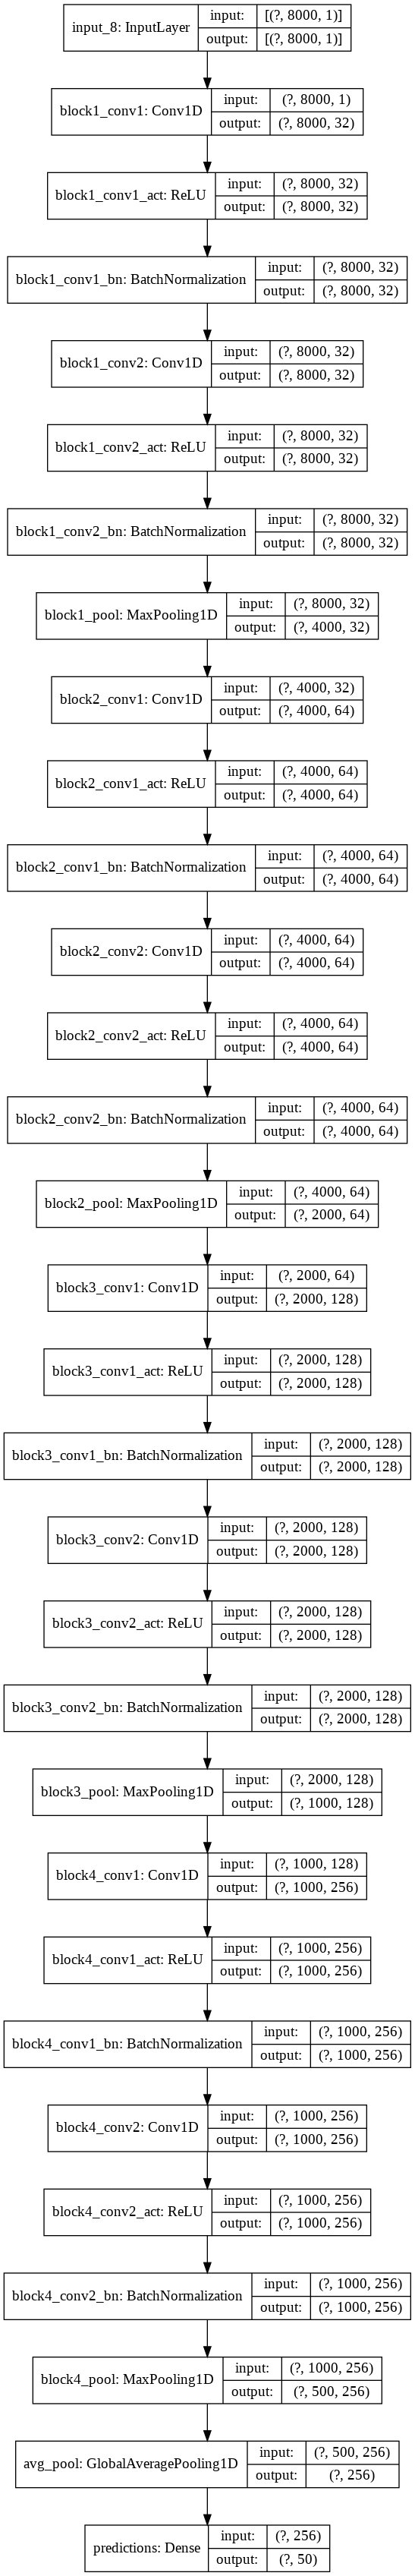

In [115]:
from tensorflow.keras.utils import plot_model

plot_model(model_1, show_shapes = True, to_file = 'model_1.png')

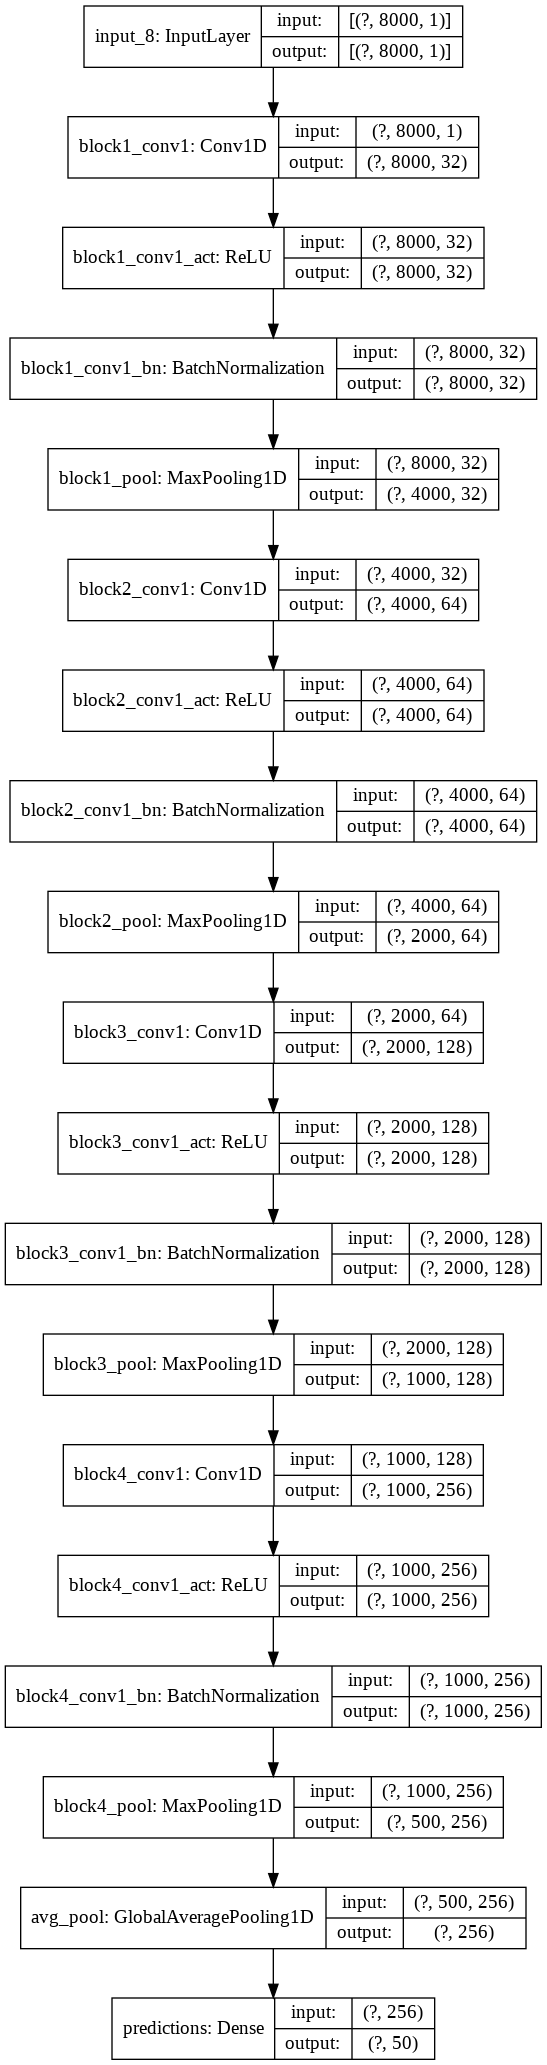

In [116]:
plot_model(model_2, show_shapes = True, to_file = 'model_2.png')

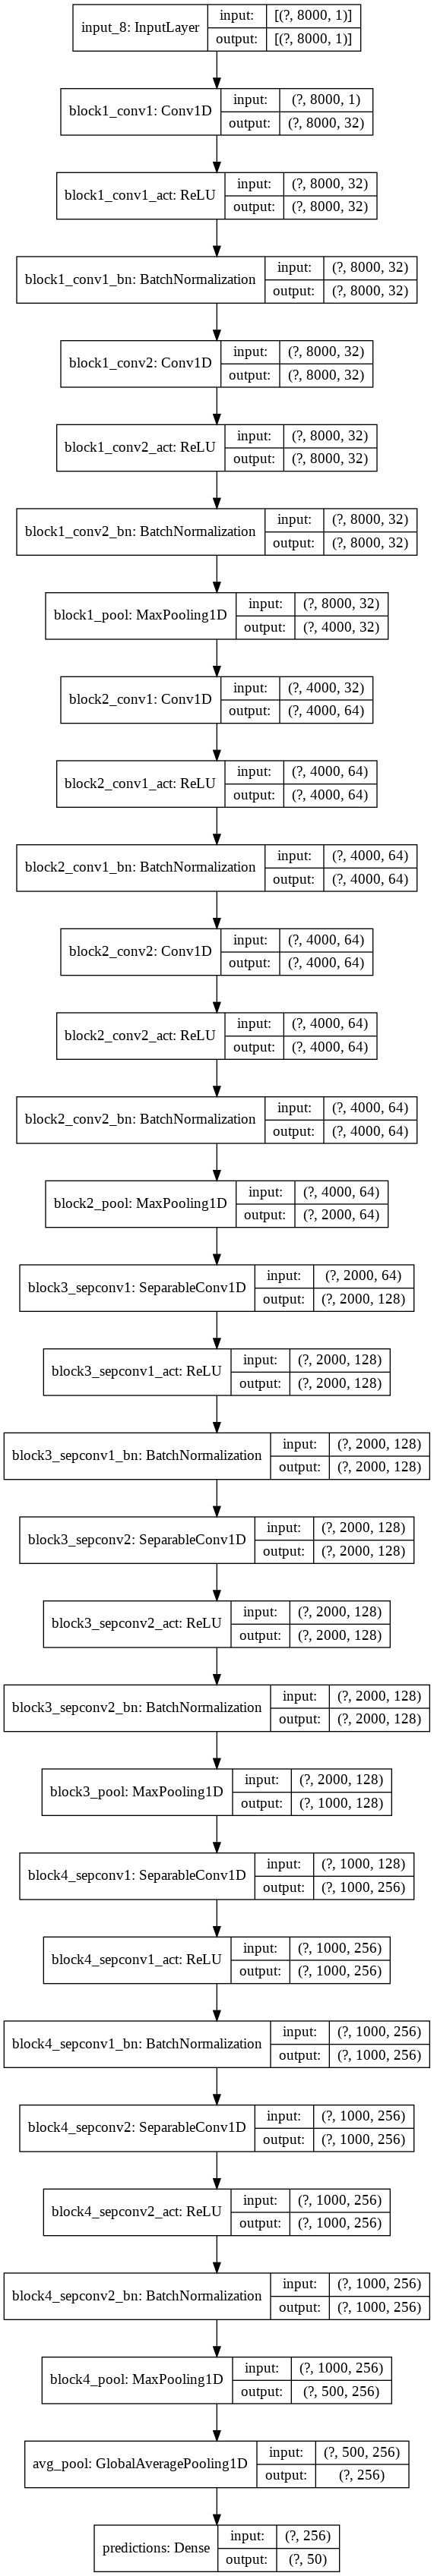

In [117]:
plot_model(model_3, show_shapes = True, to_file = 'model_3.png')

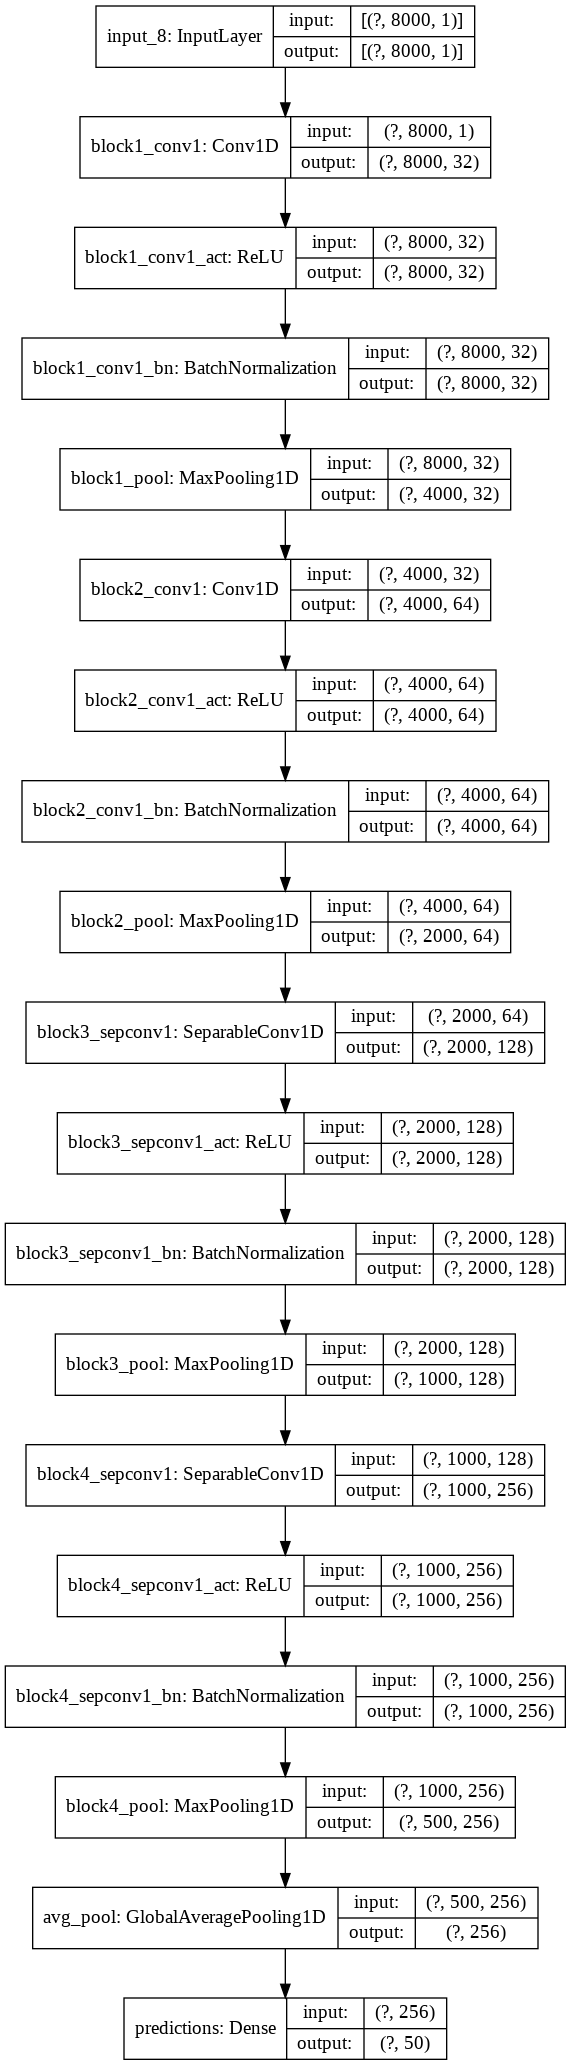

In [118]:
plot_model(model_4, show_shapes = True, to_file = 'model_4.png')

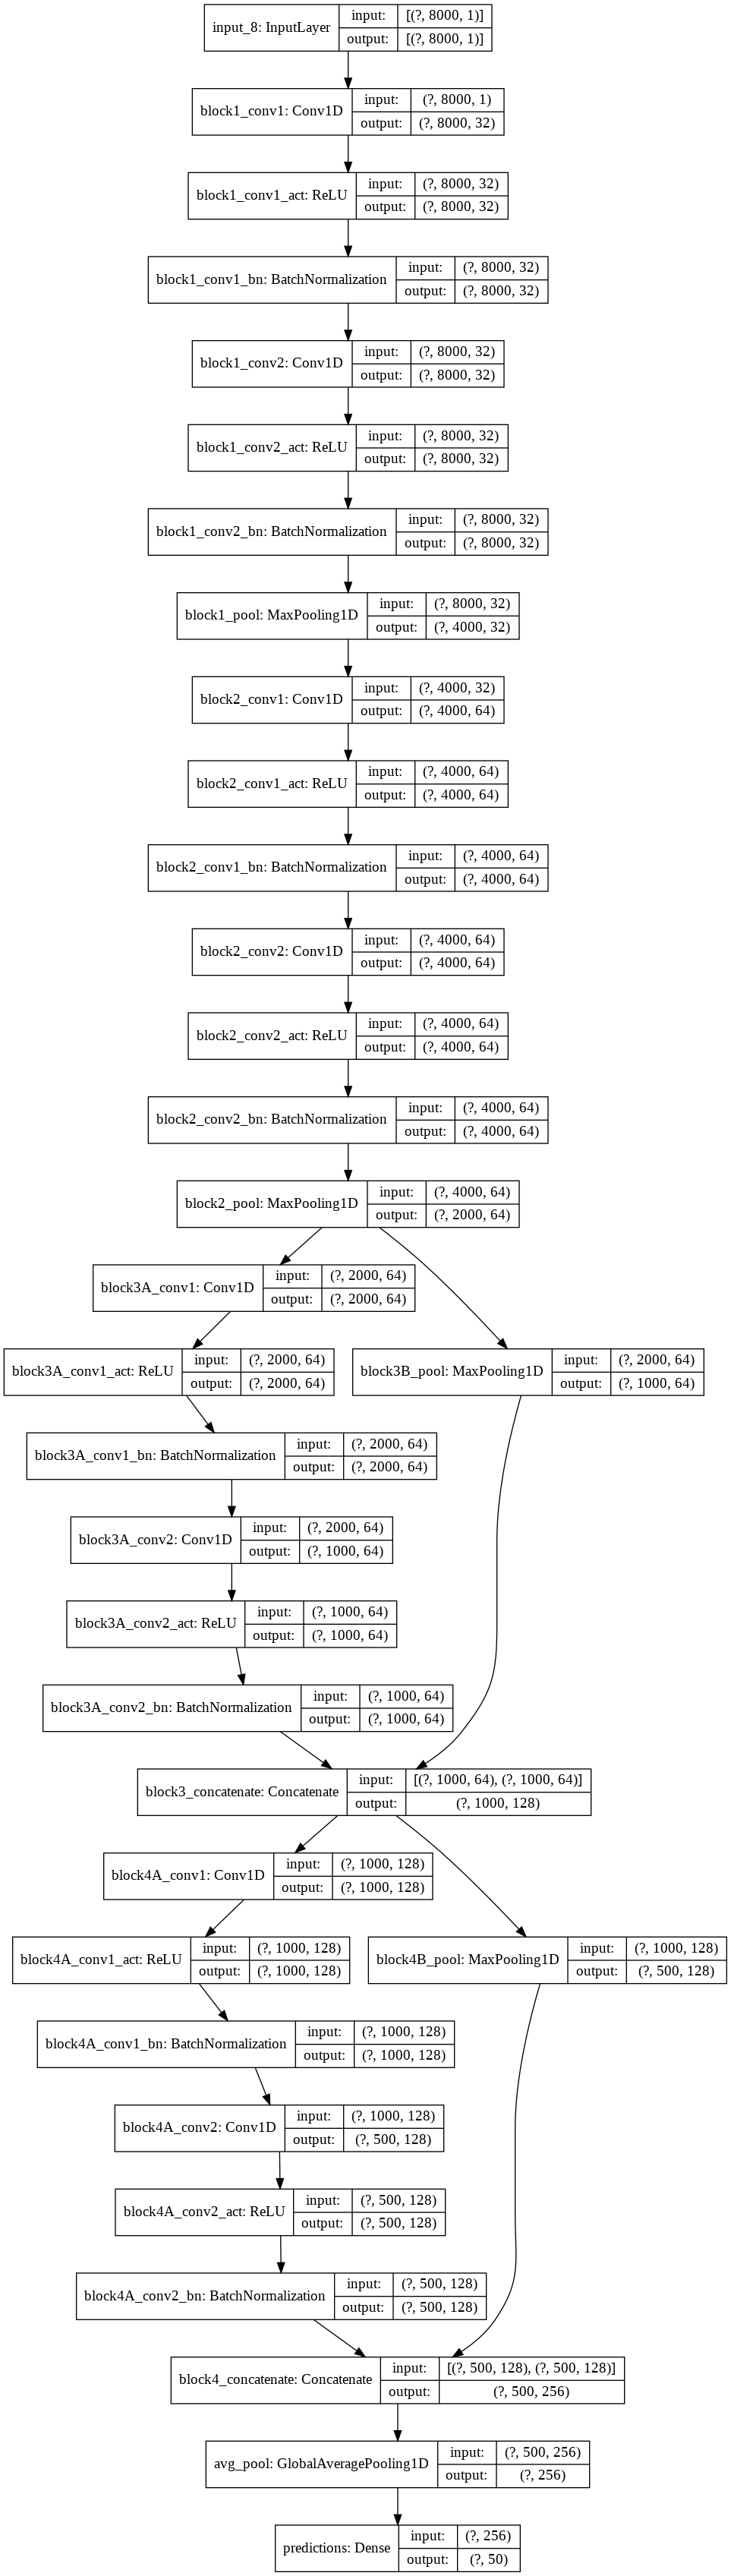

In [147]:
plot_model(model_5, show_shapes = True, to_file = 'model_5.png')

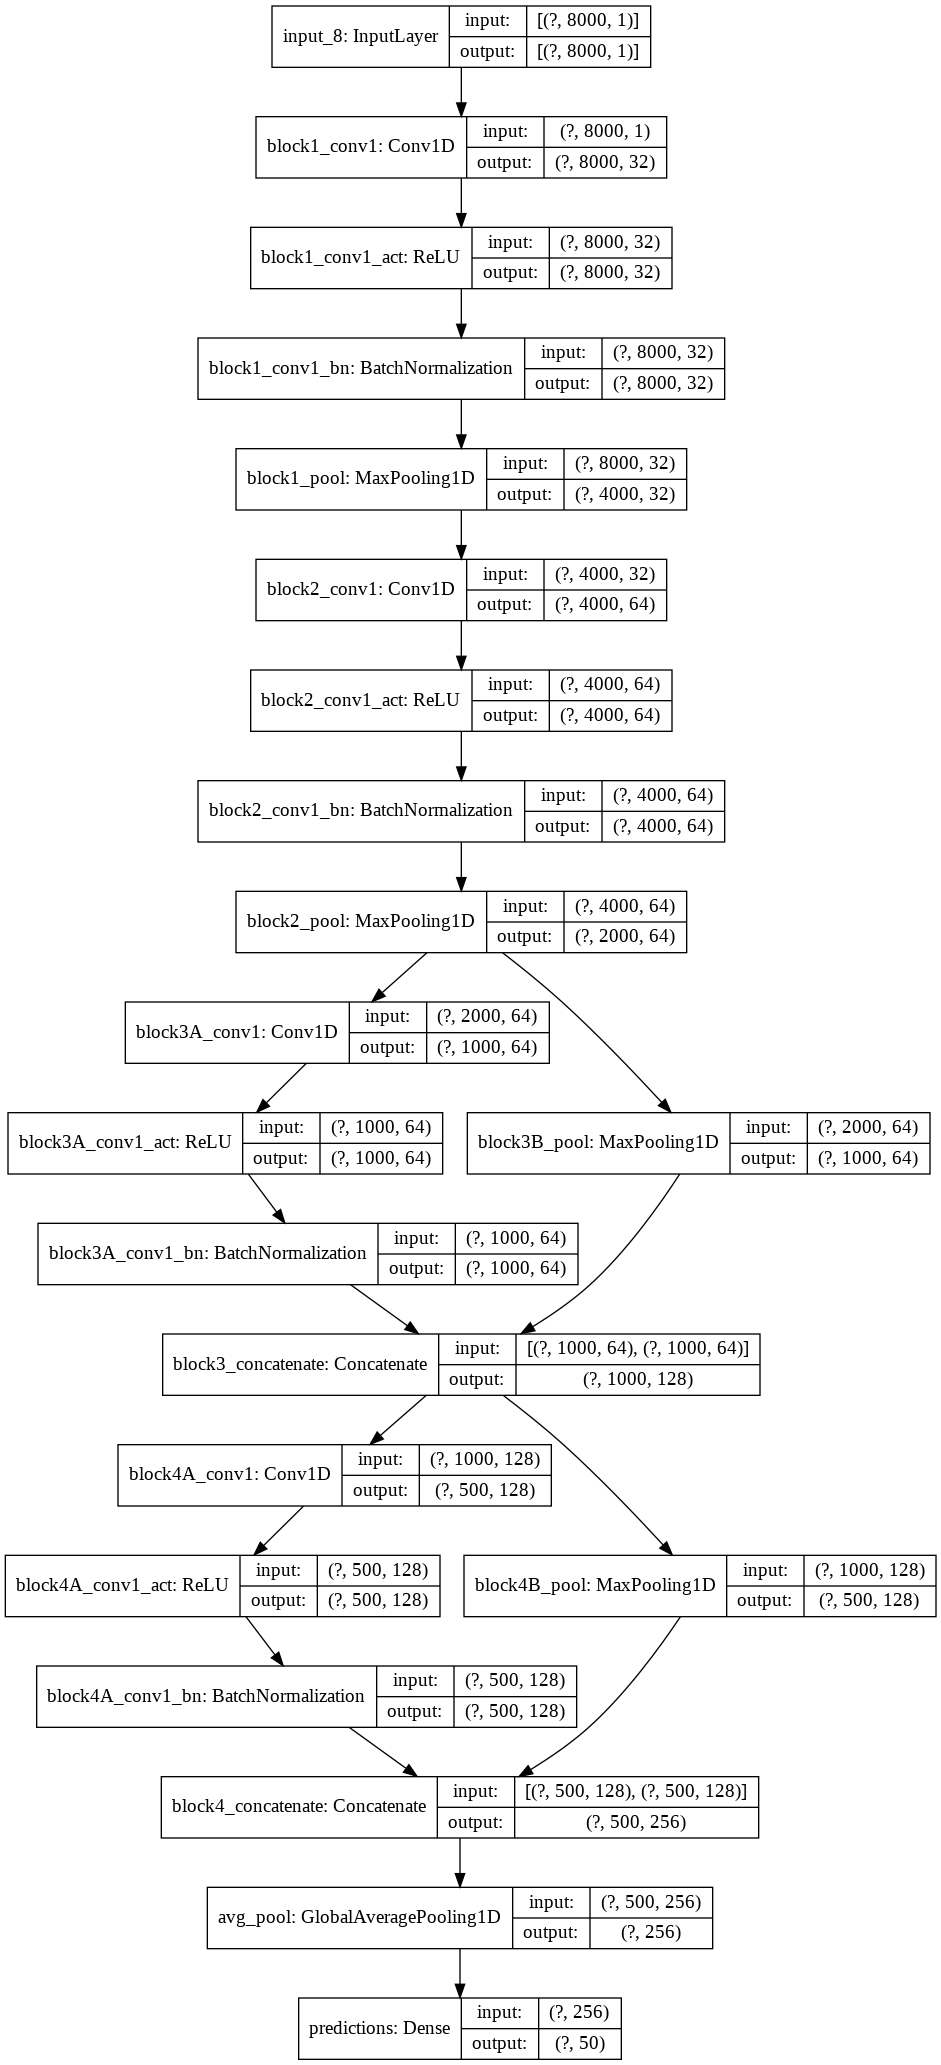

In [152]:
plot_model(model_6, show_shapes = True, to_file = 'model_6.png')

**Train model**

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import time

def compile_and_train(model, x_train, y_train, x_val, y_val, batch_size, epochs): 
    # compile
    opt = optimizers.RMSprop(lr = 0.001)
    model.compile(optimizer = opt,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    # save model & results
    save_model_path = os.path.join("/content/drive/My Drive/models", notebookName)
    save_results_path = os.path.join("/content/drive/My Drive/results", notebookName)

    if not os.path.exists(save_model_path):     os.mkdir(save_model_path)
    if not os.path.exists(save_results_path):   os.mkdir(save_results_path)

    save_model_path = os.path.join(save_model_path, model.name)
    save_results_path = os.path.join(save_results_path, model.name)

    if not os.path.exists(save_model_path):     os.mkdir(save_model_path)
    if not os.path.exists(save_results_path):   os.mkdir(save_results_path)

    # callback
    # reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 100)
    checkpoint = callbacks.ModelCheckpoint(filepath = os.path.join(save_model_path, "cp-{epoch:03d}-{val_accuracy:.4f}.ckpt"),
                                           monitor = 'val_accuracy', verbose = 0, save_best_only = True, save_weights_only = True)
    
    # train & validate
    print("Train on {} samples, validate on {} samples...".format(x_train.shape[0], x_val.shape[0]))

    start = time.time()
    print("[  start time] {}".format(time.strftime('%c', time.localtime(time.time()))))
    history = model.fit(x_train, y_train,
                        validation_data = (x_val, y_val),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 0,
                        callbacks = [checkpoint])
    end = time.time()
    print("[    end time] {}".format(time.strftime('%c', time.localtime(time.time()))))
    print("[working time] {:.2f} (sec)".format(end - start))

    # save
    # model.save(os.path.join(save_model_path, model.name) + ".h5")
    np.savez_compressed(os.path.join(save_results_path, model.name),
                        accuracy = history.history['accuracy'],
                        val_accuracy = history.history['val_accuracy'],
                        loss = history.history['loss'],
                        val_loss = history.history['val_loss'],
                        working_time = np.array([end - start]))

In [0]:
def my_evaluate(model, test_data, test_labels, batch_size):
    loss, acc = model.evaluate(test_data, test_labels, batch_size = batch_size)
    print("model name: {}, test loss: {}, test_acc: {}".format(model.name, loss, acc))

    save_eval_path = os.path.join("/content/drive/My Drive/evals", notebookName)
    if not os.path.exists(save_eval_path):     os.mkdir(save_eval_path)

    save_eval_path = os.path.join(save_eval_path, model.name)
    if not os.path.exists(save_eval_path):     os.mkdir(save_eval_path)

    pred = model.predict(test_data) # (1000, 50)
    np.save(os.path.join(save_eval_path,  model.name), pred)

**test**

In [217]:
batch_size = 128
epochs = 200

num_models = 6
num_loop = 1

model_names = []

for i in range(num_loop):
    # train test split
    x_train, y_train, x_val, y_val, mean, std = my_split(train_data, train_labels)

    # build & compile & train model
    model_input = Input(shape = (data_length, 1))
    models = [
        build_model_1(model_input, i),
        build_model_2(model_input, i),
        build_model_3(model_input, i),
        build_model_4(model_input, i),
        build_model_5(model_input, i),
        build_model_6(model_input, i)
    ]
    
    for model in models:
        compile_and_train(model, x_train, y_train, x_val, y_val, batch_size, epochs)

    # test_data
    test_data = np.load(save_test_data_name + ".npy")
    test_labels = np.load(save_test_labels_name + ".npy")

    test_data = test_data.reshape(len(test_data), data_length, 1)
    test_labels = to_categorical(test_labels)

    # standarization
    test_data -= mean
    test_data /= std 

    model_names = model_names + [model.name for model in models]

model name: original_ks3_0
model name: original_ks5_0
model name: sepconv_ks3_0
model name: sepconv_ks5_0
model name: inceptionV3_ks3_0
model name: inceptionV3_ks5_0
Train on 3200 samples, validate on 800 samples...
[  start time] Wed May 20 13:35:16 2020
[    end time] Wed May 20 13:51:53 2020
[working time] 996.19 (sec)
Train on 3200 samples, validate on 800 samples...
[  start time] Wed May 20 13:51:53 2020
[    end time] Wed May 20 14:00:36 2020
[working time] 522.83 (sec)
Train on 3200 samples, validate on 800 samples...
[  start time] Wed May 20 14:00:36 2020
[    end time] Wed May 20 14:23:06 2020
[working time] 1350.03 (sec)
Train on 3200 samples, validate on 800 samples...
[  start time] Wed May 20 14:23:06 2020
[    end time] Wed May 20 14:34:45 2020
[working time] 699.25 (sec)
Train on 3200 samples, validate on 800 samples...
[  start time] Wed May 20 14:34:45 2020
[    end time] Wed May 20 14:46:08 2020
[working time] 683.27 (sec)
Train on 3200 samples, validate on 800 samp

In [219]:
model_input = Input(shape = (data_length, 1))

new_models = [
        build_model_1(model_input, 0),
        build_model_2(model_input, 0),
        build_model_3(model_input, 0),
        build_model_4(model_input, 0),
        build_model_5(model_input, 0),
        build_model_6(model_input, 0)
]

for i, model_name in enumerate(model_names):
    checkpoint_dir = "/content/drive/My Drive/models/{}/{}".format(notebookName, model_name)
    latest = tf.train.latest_checkpoint(checkpoint_dir)

    model = new_models[i]
    model.load_weights(latest)

    opt = optimizers.RMSprop(lr = 0.001)
    model.compile(optimizer = opt,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    my_evaluate(model, test_data, test_labels, batch_size)

model name: original_ks3_0
model name: original_ks5_0
model name: sepconv_ks3_0
model name: sepconv_ks5_0
model name: inceptionV3_ks3_0
model name: inceptionV3_ks5_0
8/8 [==============================] - 0s 48ms/step - loss: 0.1902 - accuracy: 0.9490
model name: original_ks3_0, test loss: 0.19018582999706268, test_acc: 0.9490000009536743
8/8 [==============================] - 0s 25ms/step - loss: 0.2665 - accuracy: 0.9180
model name: original_ks5_0, test loss: 0.26650941371917725, test_acc: 0.9179999828338623
8/8 [==============================] - 0s 45ms/step - loss: 0.2505 - accuracy: 0.9390
model name: sepconv_ks3_0, test loss: 0.2504621148109436, test_acc: 0.9390000104904175
8/8 [==============================] - 0s 24ms/step - loss: 0.2811 - accuracy: 0.9190
model name: sepconv_ks5_0, test loss: 0.2811475992202759, test_acc: 0.9190000295639038
8/8 [==============================] - 0s 32ms/step - loss: 0.2950 - accuracy: 0.9240
model name: inceptionV3_ks3_0, test loss: 0.29497423

In [0]:
import numpy as np
import os

previous = "20200520"
num_models = 6
num_loop = 1
epochs = 200

working_time = np.zeros((num_models, num_loop))
histories = np.zeros((num_models, num_loop, 4, epochs))

for i, model_name in enumerate(model_names):
    history = np.load(os.path.join("/content/drive/My Drive/results", previous, model_name, "{}.npz".format(model_name)))

    histories[i % num_models, i // num_models, 0] = history['accuracy']
    histories[i % num_models, i // num_models, 1] = history['val_accuracy']
    histories[i % num_models, i // num_models, 2] = history['loss']
    histories[i % num_models, i // num_models, 3] = history['val_loss']

    working_time[i % num_models, i // num_models] = history['working_time']

In [320]:
avg_working_time = working_time.mean(axis = 1)
avg_histories = histories.mean(axis = 1)

print(avg_working_time.shape, avg_histories.shape)

(6,) (6, 4, 200)


In [321]:
mn = ["original_ks3", "original_ks5", "sepconv_ks3", "sepconv_ks5", "inceptionV3_ks3", "inceptionV3_ks5"]

for i in range(num_models):
    print("[{}] avg working time: {:.2f} sec".format(mn[i], avg_working_time[i]))

[original_ks3] avg working time: 996.19 sec
[original_ks5] avg working time: 522.83 sec
[sepconv_ks3] avg working time: 1350.03 sec
[sepconv_ks5] avg working time: 699.25 sec
[inceptionV3_ks3] avg working time: 683.27 sec
[inceptionV3_ks5] avg working time: 378.49 sec


In [0]:
import pandas as pd

def smooth_curve(points):
    df = pd.DataFrame(points, columns = list('A'))
    # df['A'] = df['A'].rolling(5).mean()
    df['B'] = df['A'].ewm(10).mean()
    return df['B'].to_numpy()

In [0]:
import matplotlib.pyplot as plt

def plot_histories(avg_histories):
    fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)
    c = ['r', 'g', 'b', 'm', 'k', 'c']
    # l = ["--", "-", ":", "-."]
    l = ["-"] * num_models

    plt.subplot(1, 2, 1)
    for i, history in enumerate(avg_histories):
        acc = history[0]
        val_acc = history[1]
        plt.plot(np.arange(1, len(val_acc) + 1, 1), 1 - smooth_curve(val_acc), color = c[i], label = mn[i], linewidth = 1.5, linestyle = l[i])
        plt.plot(np.arange(1, len(val_acc) + 1, 1), 1 - val_acc, alpha = .3, color = c[i], linewidth = .5, linestyle = l[i])
    plt.title('Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.ylim([-0.03, 1.03])
    # plt.yscale('log')
    plt.legend()
    plt.grid(True, linewidth = 0.4)

    plt.subplot(1, 2, 2)
    for i, history in enumerate(avg_histories):
        loss = history[2]
        val_loss = history[3]
        plt.plot(np.arange(1, len(val_loss) + 1, 1), smooth_curve(val_loss), color = c[i], label = mn[i], linewidth = 1.5, linestyle = l[i])
        plt.plot(np.arange(1, len(val_loss) + 1, 1), val_loss, alpha = .3, color = c[i], linewidth = .5, linestyle = l[i])
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linewidth = 0.4)

    plt.tight_layout()
    plt.show()

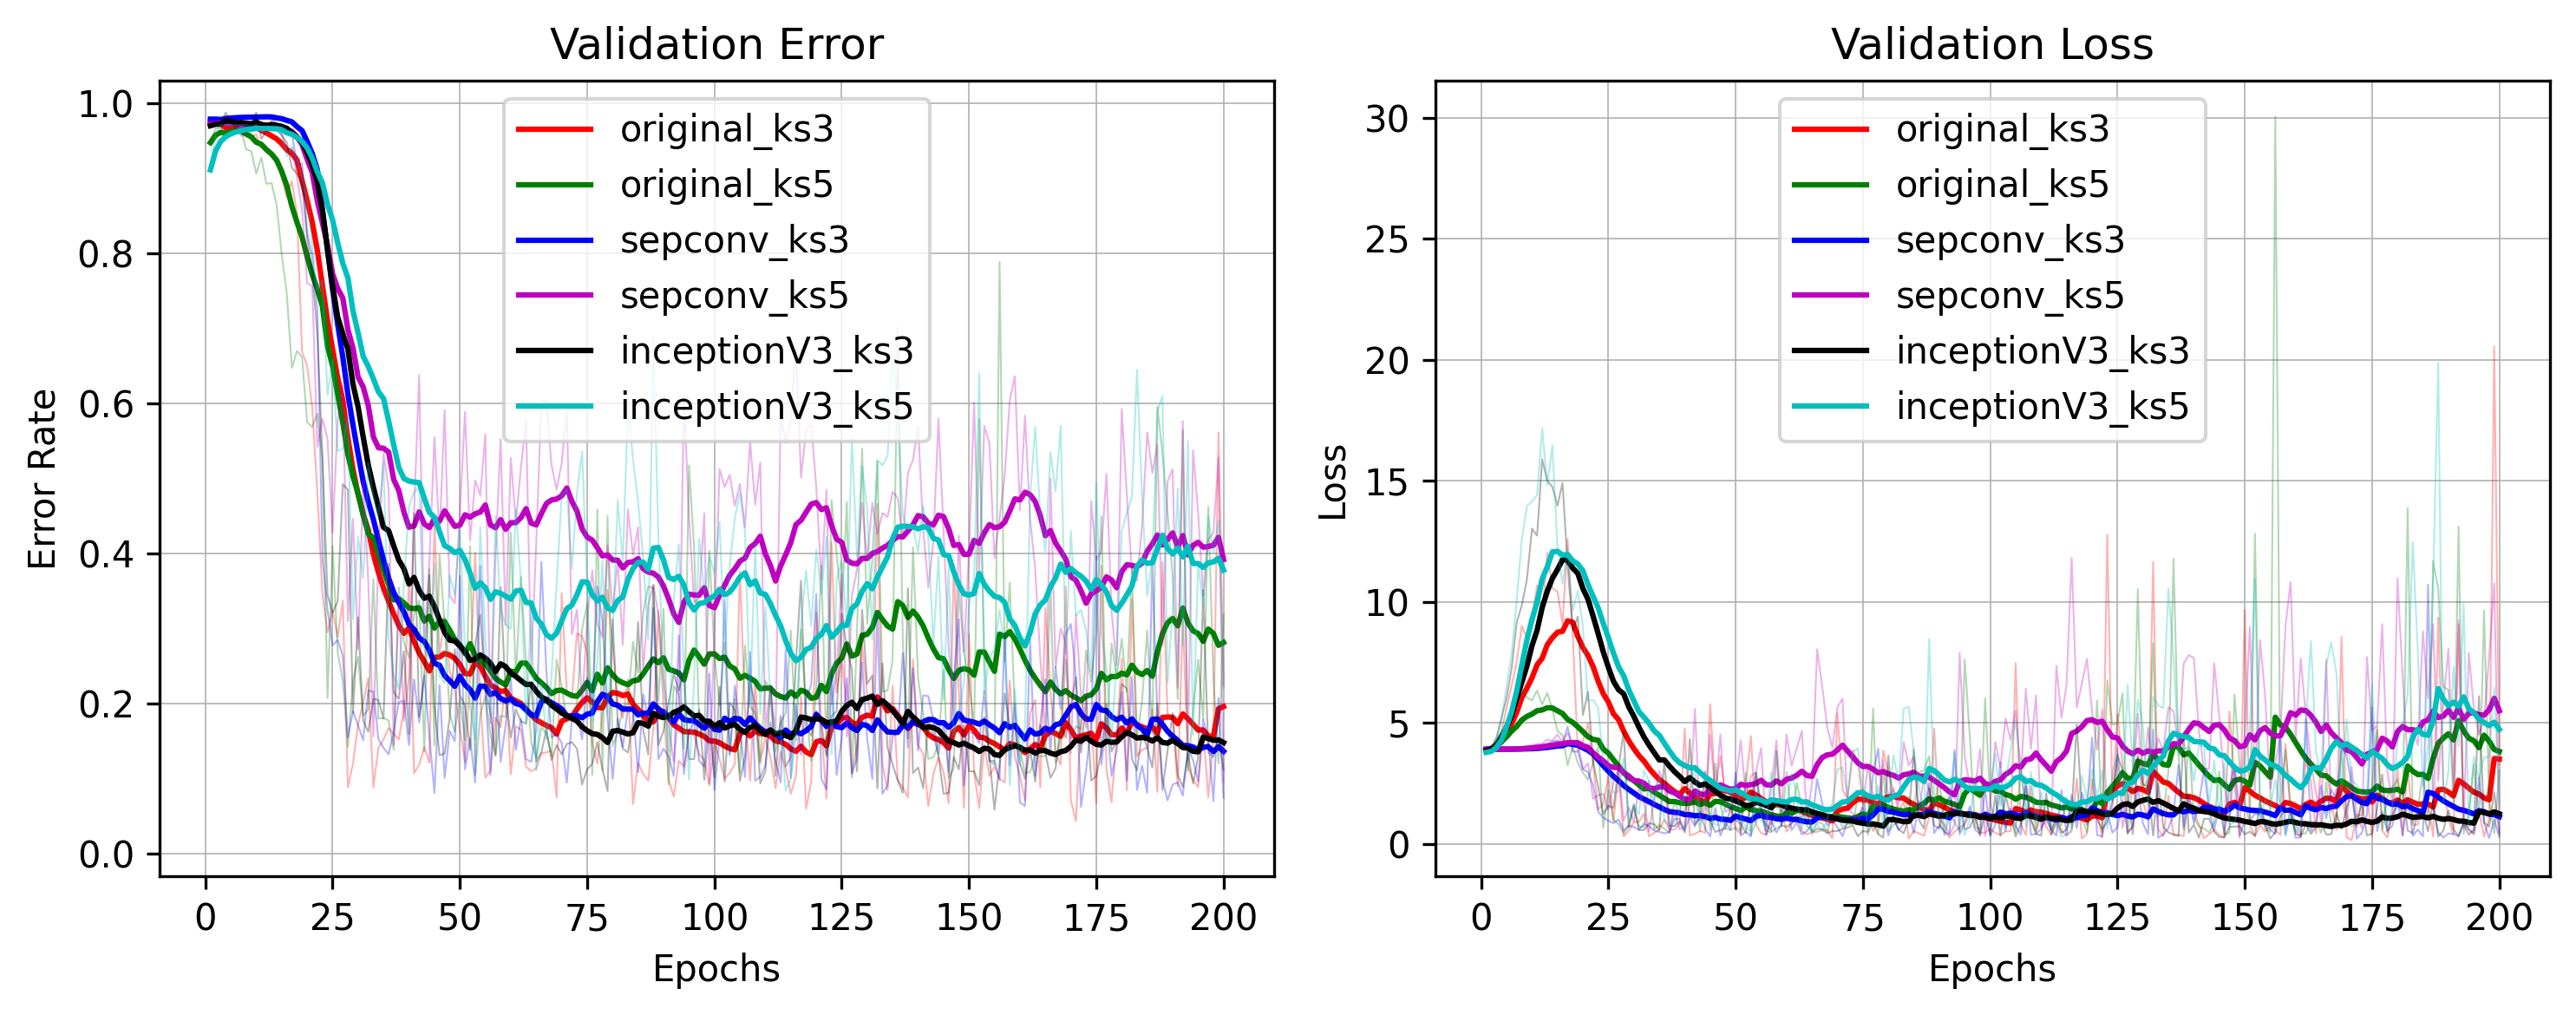

In [330]:
plot_histories(avg_histories)

In [0]:
test_labels = np.zeros((1000, 50))
num_labels = 50

In [0]:
preds = np.zeros((num_models, num_loop, test_labels.shape[0], test_labels.shape[1])) # (3, 10, 1000, 50)

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", previous, model_name, "{}.npy".format(model_name))) # (1000, 50)
    preds[i % num_models, i // num_models] = pred

In [0]:
test_errors = np.zeros((num_models, num_loop))

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", previous, model_name, "{}.npy".format(model_name))) # (1000, 50)
    y = np.array(sorted([i for i in range(num_labels)] * 20)) # (1000)
    
    test_errors[i % num_models, i // num_models] = np.sum(np.not_equal(np.argmax(pred, axis = 1), y)) / test_labels.shape[0]

In [239]:
test_errors

array([[0.051],
       [0.082],
       [0.061],
       [0.081],
       [0.076],
       [0.082]])

In [241]:
for i in range(num_models):
    print("[{}] avg test error: {:.4f}".format(mn[i], test_errors[i].mean()))

[original_ks3] avg test error: 0.0510
[original_ks5] avg test error: 0.0820
[sepconv_ks3] avg test error: 0.0610
[sepconv_ks5] avg test error: 0.0810
[inceptionV3_ks3] avg test error: 0.0760
[inceptionV3_ks5] avg test error: 0.0820


In [0]:
cmcs = np.zeros((num_models, num_loop, 50)) # (3, 10, 50)

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", previous, model_name, "{}.npy".format(model_name))) # (1000, 50)
    y = np.array(sorted([i for i in range(num_labels)] * 20)) # (1000)

    a = np.array([sorted(pred[j], reverse = True).index(pred[j, y[j]]) for j in range(len(y))]) # 정답의 순위    
    cmcs[i % num_models, i // num_models] = np.array([len(a[a<=j]) / 1000 for j in range(50)])

In [247]:
print(cmcs)

[[[0.949 0.982 0.991 0.993 0.998 0.999 0.999 0.999 0.999 0.999 0.999
   0.999 0.999 1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.   ]]

 [[0.918 0.974 0.985 0.989 0.993 0.994 0.994 0.996 0.996 0.997 0.997
   0.997 0.997 0.998 0.999 0.999 0.999 0.999 0.999 0.999 1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.   ]]

 [[0.939 0.977 0.986 0.99  0.995 0.996 0.997 0.998 0.998 0.998 0.998
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.   ]]

 [[0.919 0.97  0.985 0.991 0.992 0.994 0.995 0.998 0.999 0.999 0.999
   0

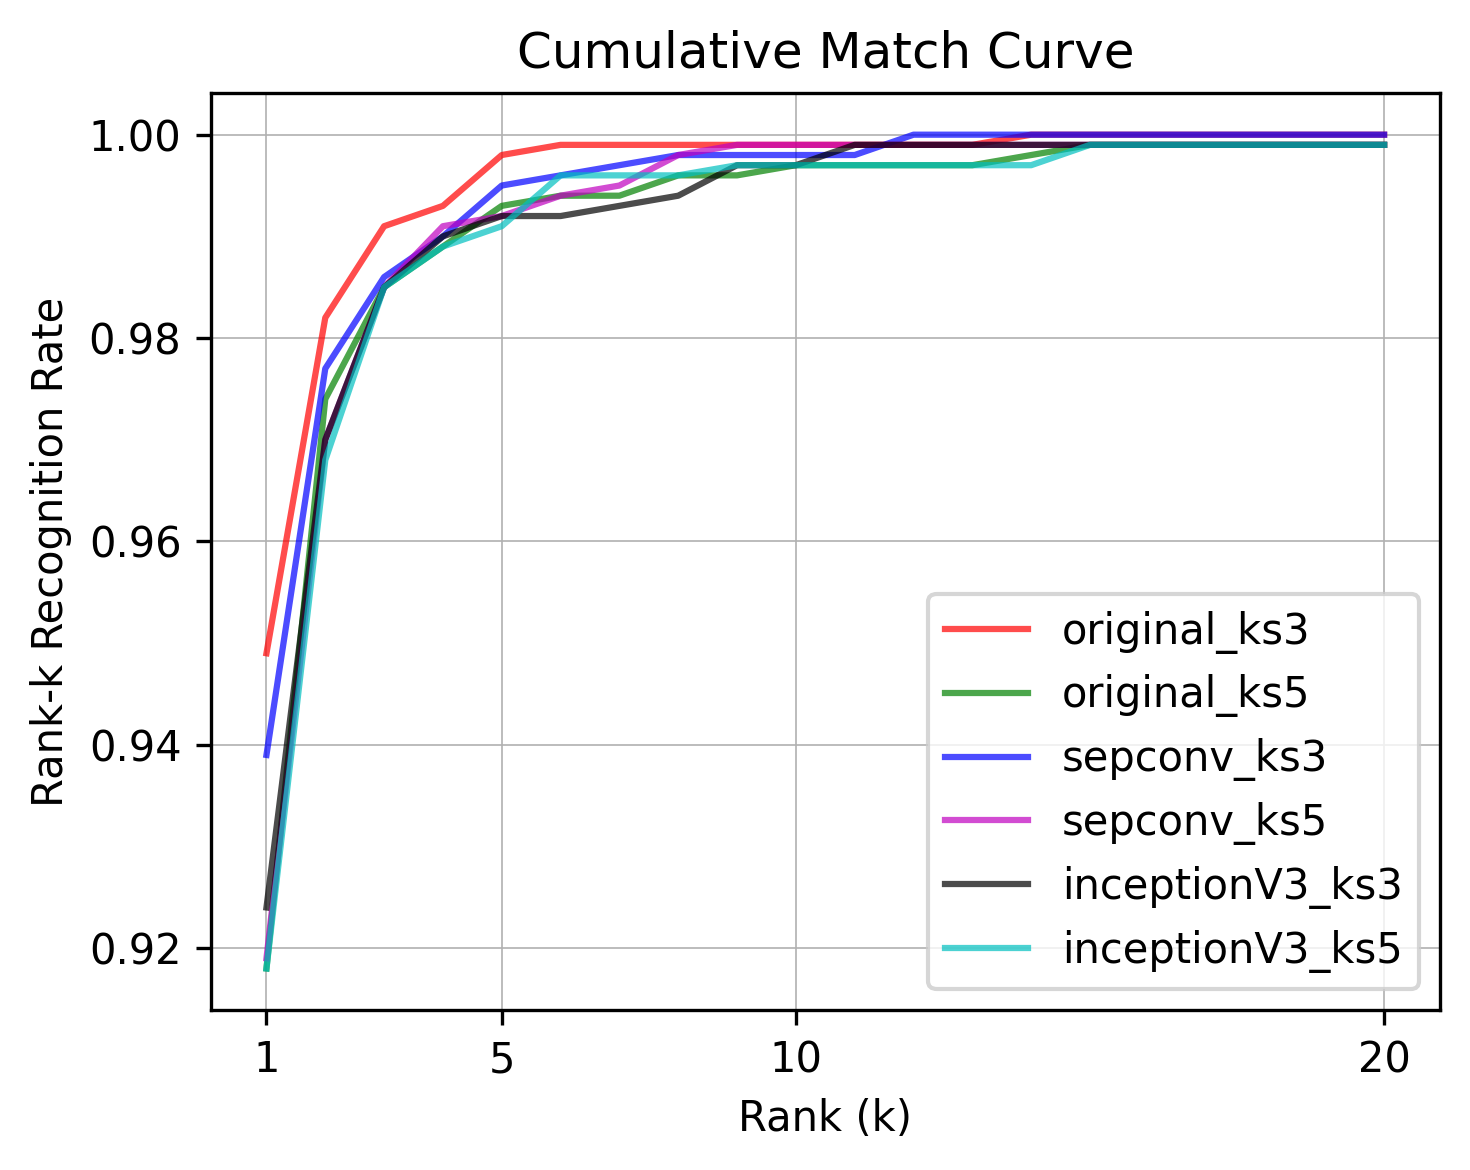

In [250]:
avg_cmcs = cmcs.mean(axis = 1)

fig = plt.figure(figsize = (5, 4), facecolor = 'white', dpi = 300)

for i, model_cmc in enumerate(avg_cmcs):
    c = ['r', 'g', 'b', 'm', 'k', 'c']
    # l = ["--", "-", ":", "-."]
    l = ["-"] * num_models

    plt.plot(np.arange(1, 21, 1), model_cmc[:20],
             color = c[i], label = mn[i], alpha = .7, linewidth = 1.5, linestyle = l[i])

plt.title('Cumulative Match Curve')
plt.xlabel('Rank (k)')
plt.ylabel('Rank-k Classification Rate')
plt.xticks([1, 5, 10, 20])
plt.legend()
plt.grid(True, linewidth = 0.4)

plt.tight_layout()
plt.show()

In [249]:
for i, cmc in enumerate(avg_cmcs):
    print("[{}] top 1 error: {:.4f}, top 5 error: {:.4f}".format(mn[i], 1 - cmc[0], 1 - cmc[4]))

[original_ks3] top 1 error: 0.0510, top 5 error: 0.0020
[original_ks5] top 1 error: 0.0820, top 5 error: 0.0070
[sepconv_ks3] top 1 error: 0.0610, top 5 error: 0.0050
[sepconv_ks5] top 1 error: 0.0810, top 5 error: 0.0080
[inceptionV3_ks3] top 1 error: 0.0760, top 5 error: 0.0080
[inceptionV3_ks5] top 1 error: 0.0820, top 5 error: 0.0090
